In [27]:
import sys; sys.path.append('../torchdyn')
from torchdyn.models import *
import torchdiffeq

##### Test method vs `torchdiffeq`

#### Runge-Kutta methods

In [28]:
import collections
ButcherTableau = collections.namedtuple('ButcherTableau', 'a, b, c, c_err')

In [85]:
class GenericExplicitButcher(nn.Module):
    def __init__(self, tableau):
        super().__init__()
        self.tab = tableau
    
    def forward(self, s, z, f, eps):
        stages = []
        for i, a in enumerate(self.tab.a): 
            stval = torch.zeros_like(z)
            for j, stage in enumerate(stages):
                # determine stage value
                stval += a[j]*stages[j]
            # evaluate f and store stage
            stages += [f(s + tableau.c[i], z + eps*stval)]
        return z + eps*sum([tableau.b[i]*stages[i] for i in range(len(tableau.b))])

#### Test Euler

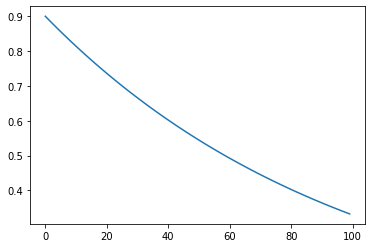

In [106]:
tableau = ButcherTableau([[0]], [1], [0], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])[None]
s_span = torch.linspace(0, 1, 100)

def odeint(f, z, solver, s_span):
    eps = s_span[1] - s_span[0]
    traj = []
    for i in s_span:
        traj += [z]
        z = solver(s, z, f, eps)
    return torch.cat(traj)

traj = odeint(f, z, solver, s_span)
import matplotlib.pyplot as plt; plt.plot(traj)

In [87]:
z = torch.Tensor([0.9])
traj_torchdiffeq = torchdiffeq.odeint(f, z, method='euler', t=torch.linspace(0, 1, 100))[:, 0]
assert((traj - traj_torchdiffeq <= 1e-2).all())

In [88]:
%timeit z = torch.Tensor([0.9]); traj_torchdiffeq = odeint(f, z, solver, s_span)

2.96 ms ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
%timeit z = torch.Tensor([0.9]); traj = torchdiffeq.odeint(f, z, method='euler', t=torch.linspace(0, 1, 100))[:, 0]

3.98 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### Test Explicit Midpoint

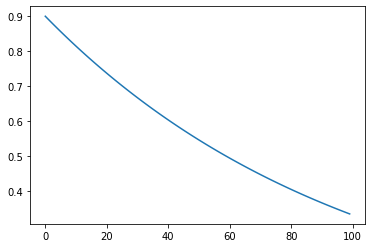

In [90]:
tableau = ButcherTableau([[0, 0], [0.5, 0]], [0, 1], [0, 0.5], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])
s_span = torch.linspace(0, 1, 100)

traj = odeint(f, z, solver, s_span)
plt.plot(traj)

In [91]:
z = torch.Tensor([0.9])
traj_torchdiffeq = torchdiffeq.odeint(f, z, method='midpoint', t=torch.linspace(0, 1, 100))[:, 0]
assert((traj - traj_torchdiffeq <= 1e-3).all())

In [92]:
%timeit z = torch.Tensor([0.9]); traj_torchdiffeq = odeint(f, z, solver, s_span)

5.27 ms ± 91.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
%timeit z = torch.Tensor([0.9]); traj = torchdiffeq.odeint(f, z, method='midpoint', t=torch.linspace(0, 1, 100))[:, 0]

5.32 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### Test Heun

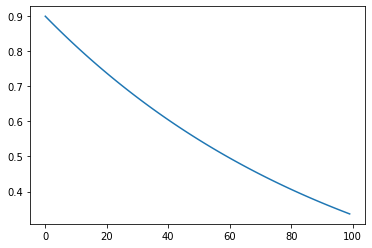

In [94]:
tableau = ButcherTableau([[0, 0], [1, 0]], [0, 1], [0.5, 0.5], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])
s_span = torch.linspace(0, 1, 100)

traj = odeint(f, z, solver, s_span)
plt.plot(traj)

##### Test Ralston

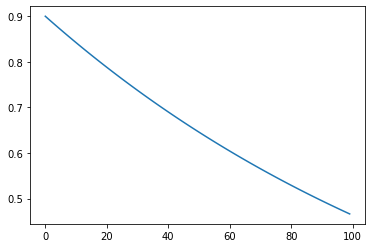

In [95]:
tableau = ButcherTableau([[0, 0], [2/3, 0]], [0, 2/3], [1/4, 3/4], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])
s_span = torch.linspace(0, 1, 100)

traj = odeint(f, z, solver, s_span)
plt.plot(traj)

##### Test Generic 2nd order (\alpha)

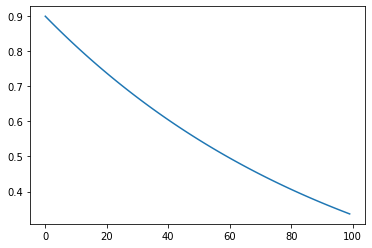

In [96]:
alpha = 1

tableau = ButcherTableau([[0, 0], [alpha, 0]], [0, alpha], [1-1/(2*alpha), 1/(2*alpha)], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])
s_span = torch.linspace(0, 1, 100)

traj = odeint(f, z, solver, s_span)
plt.plot(traj)

##### Test "Classic" RK4

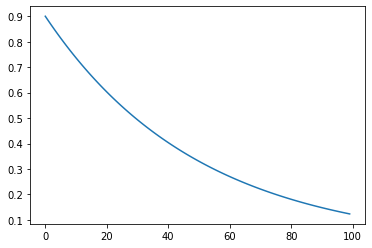

In [102]:
tableau = ButcherTableau([[0, 0, 0, 0], [0.5, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 1, 0]], [0, 0.5, 0.5, 1], [1/6, 1/3, 1/3, 1/6], [])
solver = GenericExplicitButcher(tableau)

def f(s, z): return -0.99*z
z = torch.Tensor([0.9])
s_span = torch.linspace(0, 1, 100)

traj = odeint(f, z, solver, s_span)
plt.plot(traj)

In [103]:
z = torch.Tensor([0.9])
traj_torchdiffeq = torchdiffeq.odeint(f, z, method='rk4', t=torch.linspace(0, 1, 100))[:, 0]
assert((traj - traj_torchdiffeq <= 1e-3).all())

In [104]:
%timeit z = torch.Tensor([0.9]); traj = odeint(f, z, solver, s_span)

11.5 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
%timeit z = torch.Tensor([0.9]); traj_torchdiffeq = torchdiffeq.odeint(f, z, method='rk4', t=torch.linspace(0, 1, 100))[:, 0]

11.1 ms ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
